# The *Titanic* dataset: Visual learning

##  Exploring the *Titanic* dataset with `holoviews`

<div style="width:100%; text-align:center">
<img src="https://i.ytimg.com/vi/fHJ8DwXlFyQ/maxresdefault.jpg" width=500px>
</div>

Kaggle has a nice [dataset](https://www.kaggle.com/c/titanic-gettingStarted) with information about passengers on the *Titanic*. It's meant as an introduction to predictive models -- here, predicting who survived the sinking. Let's explore it using [holoviews](http://holoviews.org/user_guide/Plotting_with_Bokeh.html).


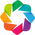

In [1]:
import numpy as np
import pandas as pd
import holoviews as hv
import scipy.stats as ss
import sklearn
from sklearn import linear_model
import seaborn as sns
%matplotlib notebook
hv.extension('bokeh')

## Examine the raw data set

In [2]:
url = "https://raw.github.com/mattdelhey/kaggle-titanic/master/Data/train.csv"
titanic = pd.read_csv(url)
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
survived    891 non-null int64
pclass      891 non-null int64
name        891 non-null object
sex         891 non-null object
age         714 non-null float64
sibsp       891 non-null int64
parch       891 non-null int64
ticket      891 non-null object
fare        891 non-null float64
cabin       204 non-null object
embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 76.6+ KB


## View data

In [3]:
titanic.head()

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Let's do  little bit of processing to make some different variables that might be more interesting to plot. Since this notebook is focused on visualization, we're going to do this without much comment.

In [4]:
def woman_child_or_man(passenger):
    age, sex = passenger
    if age < 16:
        return "child"
    else:
        return dict(male="man", female="woman")[sex]

## Process data

In [5]:
titanic["class"] = titanic.pclass.map({1: "First", 2: "Second", 3: "Third"})
titanic["who"] = titanic[["age", "sex"]].apply(woman_child_or_man, axis=1)
titanic["adult_male"] = titanic.who == "man"
titanic["deck"] = titanic.cabin.str[0].map(lambda s: np.nan if s == "T" else s)
titanic["embark_town"] = titanic.embarked.map({"C": "Cherbourg", "Q": "Queenstown", "S": "Southampton"})
titanic["alive"] = titanic.survived.map({0: "no", 1: "yes"})
titanic["alone"] = ~(titanic.parch + titanic.sibsp).astype(bool)
titanic = titanic.drop(["name", "ticket", "cabin"], axis=1)
class_order=['First', 'Second', 'Third']
deck_order = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

In [6]:
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


Finally set up a palette dictionary for some of the plots.

In [7]:
pal = dict(man="#4682B4", woman="#CD5C5C", child="#2E8B57", male="#6495ED", female="#F08080")

In [8]:
def value_count_dataset(df, column_name):
    return hv.Dataset(df.groupby(column_name).value_counts().to_dict(), kdims=[column_name], vdims=['count'])

In [9]:
def value_count_dataset2(df, columns):
    # resets index and counts index column
    data = df.reset_index()[columns + ['index']].groupby(columns).count().reset_index()
    return hv.Dataset(data, kdims=columns, vdims=[('index', 'count')])

## Who were the *Titanic* passengers?

Before getting to the main question (who survived), let's take a look at the dataset to get a sense for how the observations are distributed into the different levels of our factors of interest.

### How many men, women, and children are in our sample?

### Count the number of men and women

In [10]:
dataset = hv.Dataset(titanic, kdims=['sex'], vdims=[('alive', 'count')])
dataset.aggregate('sex', function=np.size).to(hv.Bars)

/usr/local/lib/python3.5/dist-packages/bokeh/core/json_encoder.py:33: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  if pd and isinstance(obj, pd.tslib.Timestamp):


:Bars   [sex]   (alive)

### Look at how this is distributed into the three classes.

In [11]:
dataset = hv.Dataset(titanic, kdims=['class', 'sex'], vdims=[('alive', 'count')])
bars = dataset.aggregate(['class', 'sex'], function=np.size).to(hv.Bars).sort()
bars(plot=dict(group_index='sex'))

:Bars   [class,sex]   (alive)

### Split off the children (because of the "women and children first" policy during evacuation)

In [12]:
dataset = hv.Dataset(titanic, kdims=['who'], vdims=[('alive', 'count')])
dataset.aggregate(['who'], function=np.size).to(hv.Bars)

:Bars   [who]   (alive)

### How are men, women, children distributed across classes

In [13]:
dataset = hv.Dataset(titanic, kdims=['class', 'who'], vdims=[('alive', 'count')])
bars = dataset.aggregate(['class', 'who'], function=np.size).to(hv.Bars).sort()
bars(plot=dict(group_index='who'))

:Bars   [class,who]   (alive)

### Display whether a passenger was an adult male.

In [14]:
dataset = hv.Dataset(titanic, kdims=['adult_male'], vdims=[('alive', 'count')])
dataset.aggregate(['adult_male'], function=np.size).to(hv.Bars)

:Bars   [adult_male]   (alive)

### Find adult males across classes

In [58]:
dataset = hv.Dataset(titanic, kdims=['class', 'adult_male'], vdims=[('alive', 'count')])
bars = dataset.aggregate(['class', 'adult_male'], function=np.size).to(hv.Bars).sort()
#bars(plot=dict(group_index='adult_male'))

## Distribution of ages across men and women

In [16]:
hv.BoxWhisker(titanic[~titanic.age.isnull()], kdims=['sex'], vdims=['age'])

:BoxWhisker   [sex]   (age)

### Distribution of ages across men, women and children

In [17]:
hv.BoxWhisker(titanic[~titanic.age.isnull()], kdims=['who'], vdims=['age'])

:BoxWhisker   [who]   (age)

### How many first, second, and third class passengers are in our sample?

Although have some information about the distribution into classes from the sex plots, let's directly visualize it an then see how the classes break down by age.

In [18]:
dataset = hv.Dataset(titanic, kdims=['class'], vdims=[('alive', 'count')])
dataset.aggregate(['class'], function=np.size).to(hv.Bars).sort()

:Bars   [class]   (alive)

### Ages of passengers across first, second and third class

In [19]:
hv.BoxWhisker(titanic[~titanic.age.isnull()], kdims=['class'], vdims=['age'])

:BoxWhisker   [class]   (age)

### Breakdown by age and sex.

In [20]:
dataset = hv.Dataset(titanic[~titanic.age.isnull()], kdims=['sex', 'class'], vdims=['age'])
plot = dataset.to(hv.BoxWhisker, kdims=['class'], vdims=['age']).grid()
plot.opts({'BoxWhisker': {'plot':dict(width=400, height=300)},
           'GridSpace': {'plot':dict(shared_xaxis=True, shared_yaxis=True)}})

:GridSpace   [sex]
   :BoxWhisker   [class]   (age)

## Cabins & Decks

### Where were our passenger's cabins?

We also have information about what deck each passgener's cabin was on, which may be relevant.

In [21]:
dataset = hv.Dataset(titanic, kdims=['deck'], vdims=[('alive', 'count')])
bars = dataset.aggregate(['deck'], function=np.size).to(hv.Bars)
bars = bars.sort('deck')(style=dict(color=hv.Palette('Pastel1')))
bars

:Bars   [deck]   (alive)

### Breakdown of decks by class
#### Missing a lot of cabin & deck data

In [22]:
dataset = hv.Dataset(titanic, kdims=['deck', 'class'], vdims=[('alive', 'count')])
bars = dataset.aggregate(['deck', 'class'], function=np.size).to(hv.Bars).sort()
bars = bars(style=dict(color=hv.Palette('BuPu')))
bars(plot=dict(group_index='class'))

:Bars   [deck,class]   (alive)

Note that we're missing a lot of deck data for the second and third class passengers, which will be important to keep in mind later.

## Fares & Tickets

### How much did they pay for their tickets?

Since we have data about fares, let's see how those broke down by classes.

In [23]:
bw = hv.BoxWhisker(titanic, kdims=['class'], vdims=['fare'])
bw(style=dict(box_color=hv.Palette('BuPu')))

:BoxWhisker   [class]   (fare)

### Distribution of fares by class

In [24]:
bw = hv.BoxWhisker(titanic, kdims=['class'], vdims=['fare'])
bw(style=dict(box_color=hv.Palette('BuPu')))

:BoxWhisker   [class]   (fare)

### Winsorize to remove outliers

There are some extreme outliers in the first class distribution; let's winsorize those to get a better sense for how much each class paid.

In [25]:
titanic["fare_winsor"] = titanic.fare.map(lambda f: min(f, 200))

### Display winsorized fares

In [26]:
bw = hv.BoxWhisker(titanic, kdims=['class'], vdims=['fare_winsor'])
bw = bw(style=dict(box_color=hv.Palette('BuPu')))
bw.opts(plot=dict(tools=['hover']))

:BoxWhisker   [class]   (fare_winsor)

### Mean fares by deck

How did the fares break down by deck? Let's look both at the mean and the distribution.

In [27]:
bw = hv.BoxWhisker(titanic, kdims=['deck'], vdims=['fare'])
bw(style=dict(box_color=hv.Palette('PuBu')))

:BoxWhisker   [deck]   (fare)

### Distribution of fares by deck

In [28]:
bw = hv.BoxWhisker(titanic, kdims=['deck'], vdims=['fare'])
bw(style=dict(box_color=hv.Palette('PuBu')))

:BoxWhisker   [deck]   (fare)

### Median fares by deck

It might make more sense to plot the median fare, since the distributions aren't normal.

In [29]:
fare = hv.Dimension('fare', label='median fare')
dataset = hv.Dataset(titanic, kdims=['deck'], vdims=[fare])
bars = dataset.aggregate(['deck'], function=np.median).to(hv.Bars).sort()
bars(style=dict(color=hv.Palette('PuBu')))

:Bars   [deck]   (fare)

### Regression of fares by age

We can also look at a regression of fare on age to see if older passengers paid more. We'll use robust methods here too, which will accound for the skewed distribution on fare.

In [30]:
valid_df = titanic[~titanic.age.isnull()]

# convert to 2d array
age = valid_df.age.values
age_X = age.reshape((-1, 1))

regr = sklearn.linear_model.LinearRegression()
regr.fit(age_X, valid_df.fare)
fare_pred = regr.predict(age_X)

reg_points = np.stack((age, fare_pred), axis=1)
reg_line = hv.Curve(reg_points)(style=dict(color='red'))
reg_scatter = hv.Scatter(valid_df, kdims=['age'], vdims=['fare'])(style=dict(color='seagreen', size=5))
plot = reg_scatter * reg_line
plot.opts({'Scatter': {'plot': dict(width=400, tools=['hover'])}})

:Overlay
   .Scatter.I :Scatter   [age]   (fare)
   .Curve.I   :Curve   [x]   (y)

## Port of embarkation

### Where did the passengers come from?

The *Titanic* passengers embarked at one of three ports before the voyage.

In [31]:
dataset = hv.Dataset(titanic, kdims=['class', 'embark_town'], vdims=[('alive', 'count')])
bars = dataset.aggregate(['class', 'embark_town'], function=np.size).to(hv.Bars).sort()
bars = bars(style=dict(color=hv.Palette('Set2')))
bars(plot=dict(group_index='embark_town'))

:Bars   [class,embark_town]   (alive)

## Who was traveling with family members?

We also have some data, although it's not coded very well, about the number of parents/children and the numbe of siblings/spouses on board for each passenger.

### Passengers traveling with parents & children

In [32]:
dataset = hv.Dataset(titanic, kdims=['class', 'parch'], vdims=[('alive', 'count')])
bars = dataset.aggregate(['class', 'parch'], function=np.size).to(hv.Bars).sort()
bars = bars(style=dict(color=hv.Palette('BuGn')))
bars(plot=dict(group_index='parch', legend_position='left'))

:Bars   [class,parch]   (alive)

### Passengers traveling with spouses & siblings

In [33]:
dataset = hv.Dataset(titanic, kdims=['class', 'sibsp'], vdims=[('alive', 'count')])
bars = dataset.aggregate(['class', 'sibsp'], function=np.size).to(hv.Bars).sort()
bars = bars(style=dict(color=hv.Palette('YlGn')))
bars(plot=dict(group_index='sibsp', legend_position='left'))

:Bars   [class,sibsp]   (alive)

### Define a variable for those traveling alone

We defined a variable that just measures whether someone was traveling alone, i.e. without family.

In [34]:
dataset = hv.Dataset(titanic, kdims=['alone'], vdims=[('alive', 'count')])
bars = dataset.aggregate(['alone'], function=np.size).to(hv.Bars)
bars(style=dict(color=hv.Palette('Greens')))

:Bars   [alone]   (alive)

## What made people survive the sinking?

<div style="width:100%; text-align:center">
<i>Iceberg, dead ahead!</i><br><br>
<img src=http://upload.wikimedia.org/wikipedia/en/b/bb/Titanic_breaks_in_half.jpg width=500px>
</div>

Now that we have a feel for the characteristics of our sample, let's get down to the main question and ask what factors seem to predict whether our passengers survived. But first, one more count plot just to see how many of our passengers perished in the sinking.

### Number of people who survived

In [35]:
dataset = hv.Dataset(titanic, kdims=['alive'], vdims=[('sex', 'count')])
bars = dataset.aggregate(['alive'], function=np.size).to(hv.Bars)
bars(style=dict(color=hv.Palette('OrRd')))

:Bars   [alive]   (sex)

### What classes had the survivors traveled in?

It's part of popular lore that the third-class (or steerage) passengers fared much more poorly than their wealthier shipmates. Is this borne out in the data?

In [36]:
dataset = hv.Dataset(titanic, kdims=['class'], vdims=['survived'])
# calculate mean and standard error mean
agg = dataset.aggregate(['class'], function=np.mean, spreadfn=ss.sem)
curve = hv.Curve(agg, extents=(None, 0, None, 1)).sort()
error = hv.ErrorBars(agg, vdims=['survived', 'survived_sem'])
curve * error

:Overlay
   .Curve.I     :Curve   [class]   (survived,survived_sem)
   .ErrorBars.I :ErrorBars   [class]   (survived,survived_sem)

### Third class survival low because disproportionately male?

We also of course know that women were given high priority during the evacuation, and we saw above that Third class was disproportionately male. Maybe that's driving the class effect?

In [37]:
extents = (None, 0, None, 1)
dataset = hv.Dataset(titanic, kdims=['class', 'sex'], vdims=['survived'])
# calculate mean and standard error mean
agg = dataset.aggregate(['class', 'sex'], function=np.mean, spreadfn=ss.sem).sort('class')
curves = agg.to(hv.Curve, extents=extents, groupby='sex')
errors = agg.to(hv.ErrorBars, extents=extents, groupby='sex')
# alternatively: plots = curves * errors
plots = curves.overlay() * errors.overlay()
plots.opts({'Curve': {'plot':dict(width=400, height=300)},
            'GridSpace': {'plot':dict(shared_xaxis=True, shared_yaxis=True)}})

:Overlay
   .NdOverlay.I  :NdOverlay   [sex]
      :Curve   [class]   (survived,survived_sem)
   .NdOverlay.II :NdOverlay   [sex]
      :ErrorBars   [class]   (survived,survived_sem)

#### Nope, in general it was not good to be a male *or* to be in steerage.

### What effect did "women and children first" have?

#### Were they at least successful in evacuating the children?

In [38]:
extents = (None, 0, None, 1)
dataset = hv.Dataset(titanic, kdims=['class', 'who'], vdims=['survived'])
# calculate mean and standard error mean
agg = dataset.aggregate(['class', 'who'], function=np.mean, spreadfn=ss.sem).sort('class')
curves = agg.to(hv.Curve, extents=extents, groupby='who')
errors = agg.to(hv.ErrorBars, extents=extents, groupby='who')
plots = curves.grid() * errors.grid()
plots.opts({'Curve': {'plot':dict(width=300, height=300)},
            'GridSpace': {'plot':dict(shared_xaxis=True, shared_yaxis=True)}})

:GridSpace   [who]
   :Overlay
      .Curve.I     :Curve   [class]   (survived,survived_sem)
      .ErrorBars.I :ErrorBars   [class]   (survived,survived_sem)

Pretty good for first and second class (although the precise estimates are unreliable because there weren't that many children traveling in the upper classes. It's actually the case that every second-class child survived, though).

We suspect that the best way to predict survival is to look at whether a passenger was an adult male and what class he or she was in.


### Adult male & class best predictors?

In [39]:
extents = (None, 0, None, 1)
dataset = hv.Dataset(titanic, kdims=['class', 'adult_male'], vdims=['survived'])
# calculate mean and standard error mean
agg = dataset.aggregate(['class', 'adult_male'], function=np.mean, spreadfn=ss.sem).sort('class')
curves = agg.to(hv.Curve, extents=extents, groupby='adult_male')
errors = agg.to(hv.ErrorBars, extents=extents, groupby='adult_male')
plots = curves.overlay() * errors.overlay()
plots.opts({'Curve': {'plot':dict(width=400, height=300)},
            'GridSpace': {'plot':dict(shared_xaxis=True, shared_yaxis=True)}})

:Overlay
   .NdOverlay.I  :NdOverlay   [adult_male]
      :Curve   [class]   (survived,survived_sem)
   .NdOverlay.II :NdOverlay   [adult_male]
      :ErrorBars   [class]   (survived,survived_sem)

### More dramatic plots of adult male survival differences

Another way to plot the same data emphasizes the different outcomes for men and other passengers even more dramatically.

In [40]:
# adding another column as holoview aggregate does not work with boolean
titanic['adult_male_str'] = titanic.adult_male.map(lambda v: 'true' if v else 'false')

In [41]:
extents = (None, 0, None, 1)
dataset = hv.Dataset(titanic, kdims=['adult_male_str', 'class'], vdims=['survived'])
# calculate mean and standard error mean
agg = dataset.aggregate(['adult_male_str', 'class'], function=np.mean, spreadfn=ss.sem).sort()
curves = agg.to(hv.Curve, extents=extents, groupby='class')
plots = curves.grid()
plots.opts({'Curve': {'plot':dict(width=200, height=200), 'style': dict(color=hv.Palette('BuPu'))},
            'GridSpace': {'plot':dict(shared_xaxis=True, shared_yaxis=True)}})

:GridSpace   [class]
   :Curve   [adult_male_str]   (survived,survived_sem)

### Did age matter in general?

We can also ask whether age as a contiunous variable mattered. We'll draw logistic regression plots, first jittering the survival datapoints to get a sense of the distribution.

In [42]:
# convert to 2d array
valid_df = titanic[~titanic.age.isnull()]

age = valid_df.age.values
age_X = age.reshape((-1, 1))

regr = sklearn.linear_model.LogisticRegression()
regr.fit(age_X, valid_df.survived)
survived_pred = regr.predict_proba(age_X)

reg_points = np.stack((age, survived_pred[:, 1]), axis=1)
reg_scatter = hv.Scatter(titanic, kdims=['age'], vdims=['survived'])
reg_line = hv.Curve(reg_points)(style=dict(color='red'))
plots = reg_scatter * reg_line
plots.opts({'Scatter': {'plot': dict(width=400, tools=['hover']), 'style': dict(size=8)}})

:Overlay
   .Scatter.I :Scatter   [age]   (survived)
   .Curve.I   :Curve   [x]   (y)

### Group age into bins when plotting survival probability

We can also plot the same data with the survival observations grouped into discrete bins.

<IPython.core.display.Javascript object>


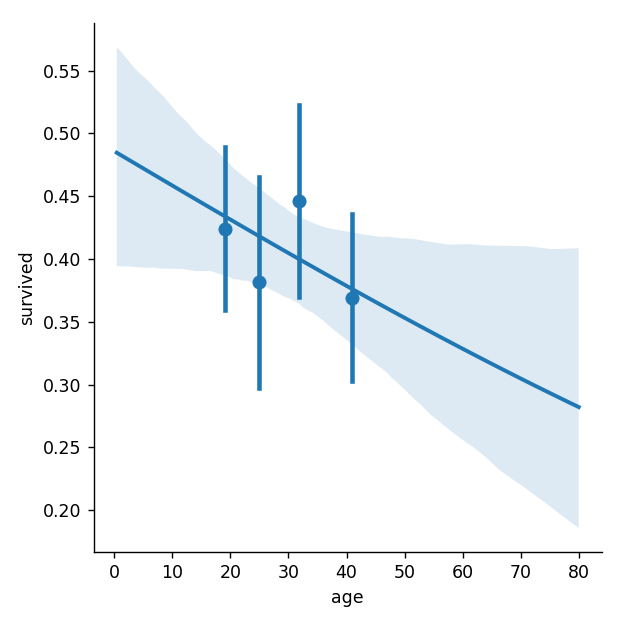

In [43]:
sns.lmplot("age", "survived", titanic, logistic=True, x_bins=4, truncate=True);

### How did age interact with sex and class?

We know that sex is important, though, so we probably want to separate out these predictions for men and women.

<IPython.core.display.Javascript object>


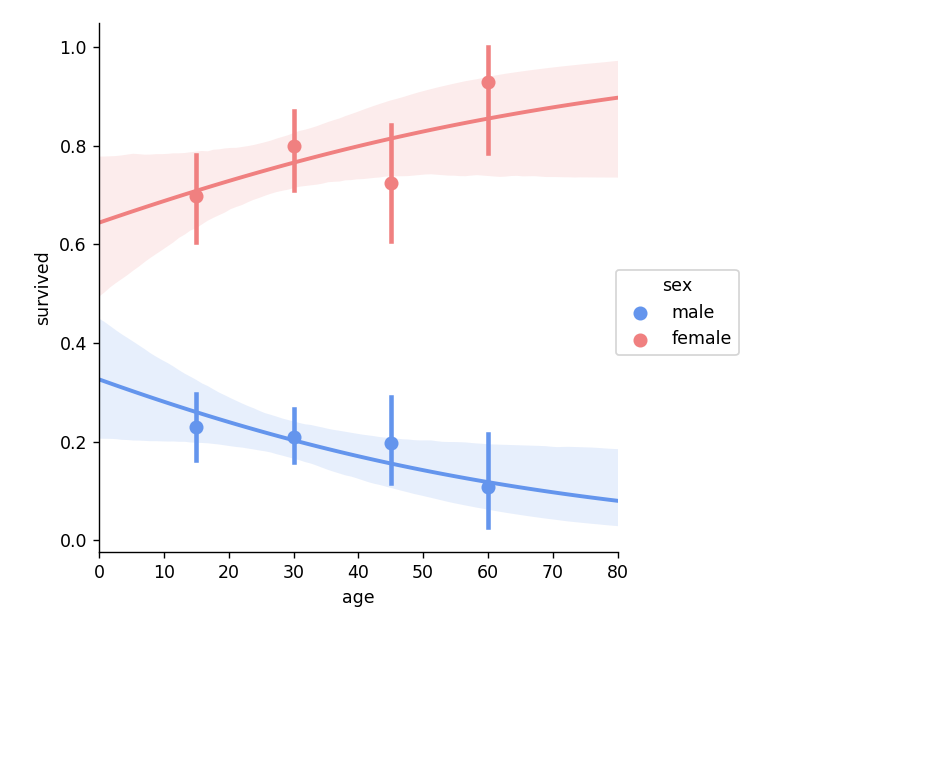

In [44]:
age_bins = [15, 30, 45, 60]
sns.lmplot("age", "survived", titanic, hue="sex",
           palette=pal, x_bins=age_bins, logistic=True).set(xlim=(0, 80));

### How does class interact with age

Class is imporant too, let's see whether it interacts with the age variable as well.

<IPython.core.display.Javascript object>


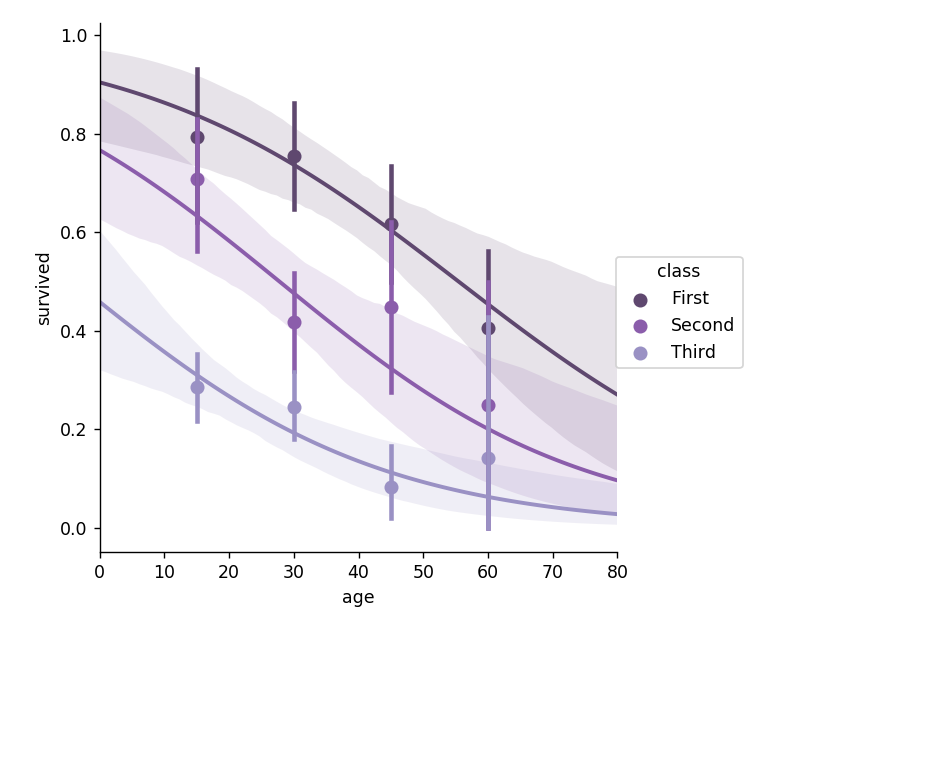

In [45]:
sns.lmplot("age", "survived", titanic, hue="class", hue_order=class_order,
           palette="BuPu_d", x_bins=age_bins, logistic=True).set(xlim=(0, 80));

### Plot the interaction of class and age on three separate plots

Because the above plot is rather busy, it might make sense to split the three classes onto separate facets.

<IPython.core.display.Javascript object>


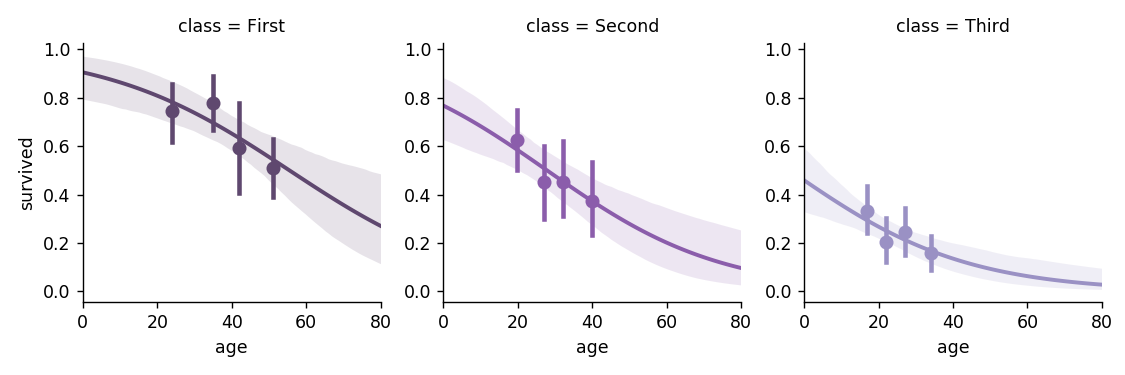

In [46]:
sns.lmplot("age", "survived", titanic, col="class", col_order=class_order, hue="class", hue_order=class_order,
           palette="BuPu_d", x_bins=4, logistic=True, size=3).set(xlim=(0, 80));

### Did it matter what passengers paid, or where they stayed?

We know that class matters, but we can also use the `fare` variable as a proxy for a contiuous measure of wealth.

<IPython.core.display.Javascript object>


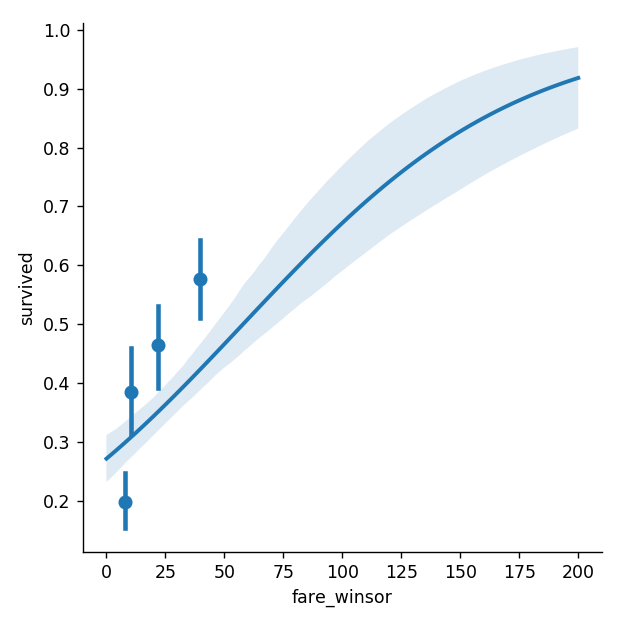

In [47]:
sns.lmplot("fare_winsor", "survived", titanic, x_bins=4, logistic=True, truncate=True);

### Perhaps the deck mattered

Perhaps it mattered what deck each passenger's cabin was on?

<IPython.core.display.Javascript object>


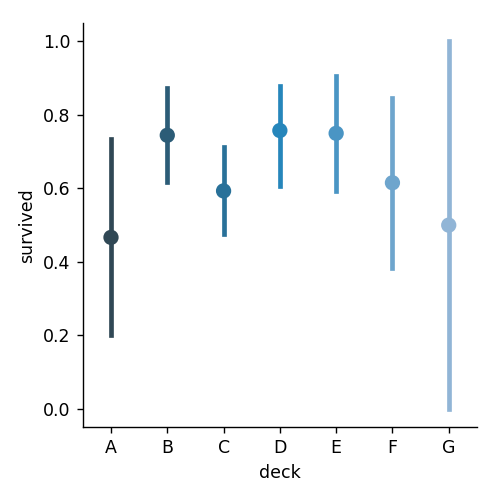

In [48]:
sns.factorplot("deck", "survived", data=titanic, order=deck_order, palette="PuBu_d", join=False);

### How did the deck interact with class

<IPython.core.display.Javascript object>


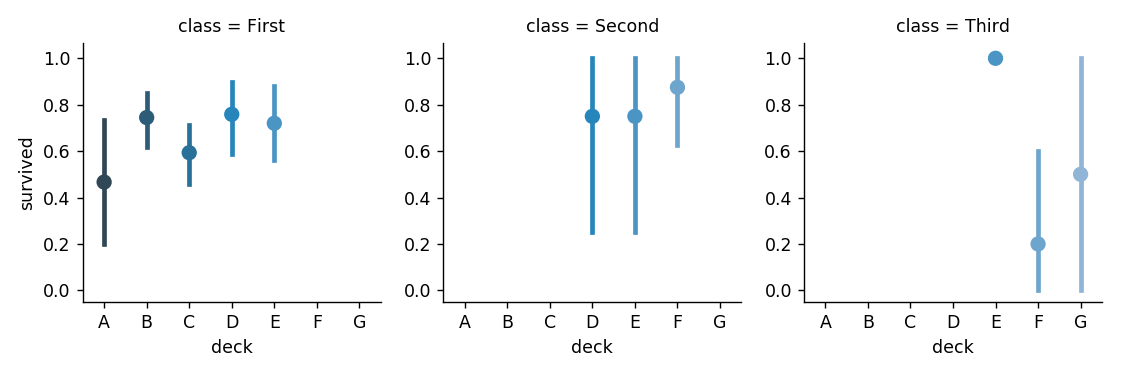

In [49]:
sns.factorplot("deck", "survived", data=titanic, order=deck_order, col="class", col_order=class_order,
               size=3, palette="PuBu_d", join=False);

### Did family members increase the odds of survival?

Although the way our data on family members was coded, we don't know for sure what sort of companions these passengers had, but it's worth asking how they influenced survival.

<IPython.core.display.Javascript object>


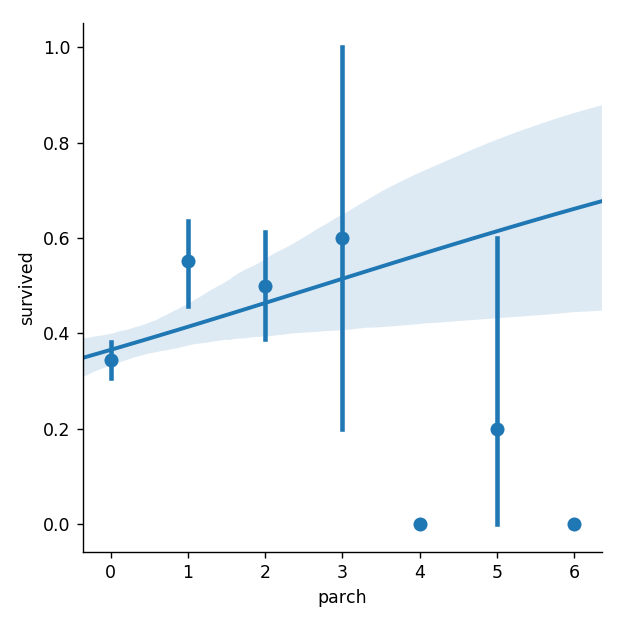

In [50]:
sns.lmplot("parch", "survived", titanic, x_estimator=np.mean, logistic=True);

### How did family members affect male/female survival?

<IPython.core.display.Javascript object>


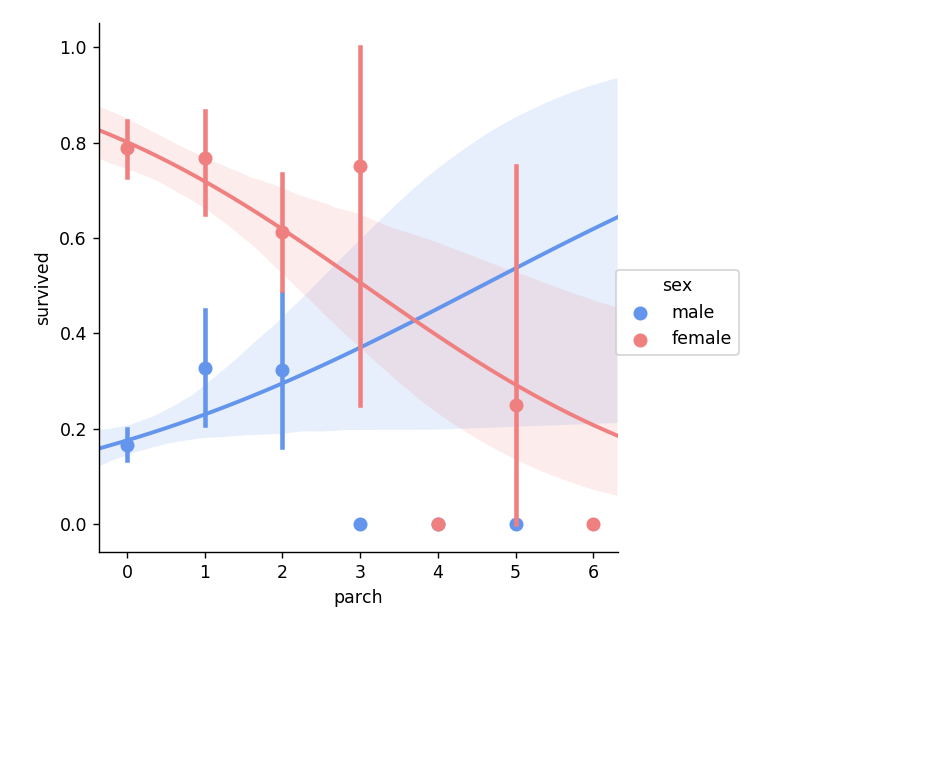

In [51]:
sns.lmplot("parch", "survived", titanic, hue="sex", x_estimator=np.mean, logistic=True, palette=pal);

### Did the presences of siblings/spouse affect survival

<IPython.core.display.Javascript object>


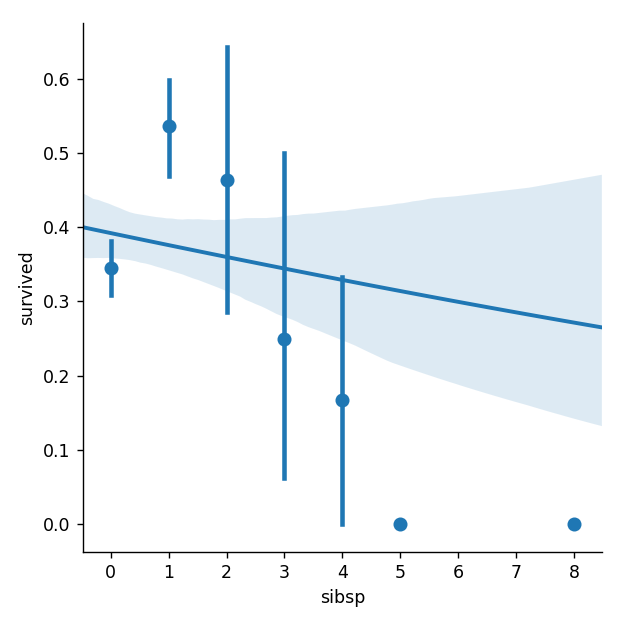

In [52]:
sns.lmplot("sibsp", "survived", titanic, x_estimator=np.mean, logistic=True);

### Effect of the *alone* variable on survival (confounded with age)

We also have a more interpretable `alone` variable (although it's reasonable to assume that this is going to be confounded with age).

<IPython.core.display.Javascript object>


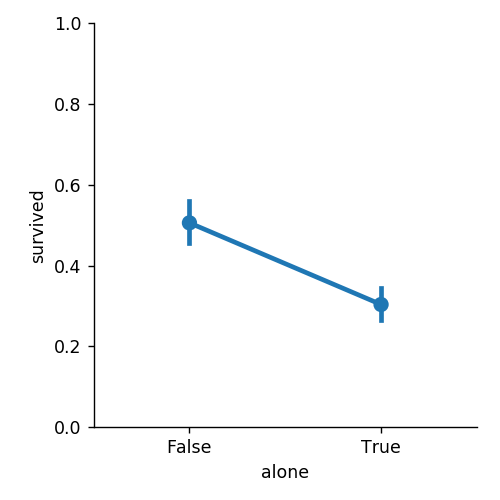

In [53]:
sns.factorplot("alone", "survived", data=titanic).set(ylim=(0, 1));

### Traveling alone affected by class?

Did traveling alone have a greater effect depending on what class you were in?

<IPython.core.display.Javascript object>


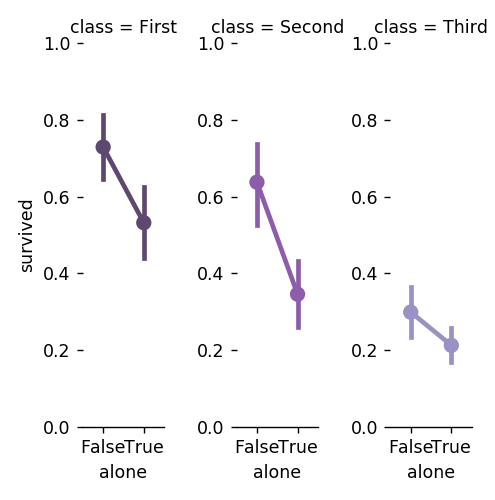

In [54]:
fg = sns.factorplot("alone", "survived", data=titanic, col="class", col_order=class_order,
                    hue="class", hue_order=class_order,
                    aspect=.33, palette="BuPu_d")
fg.set(ylim=(0, 1))
fg.despine(left=True);

### Different way to present the effect of traveling alone

As above, a different presentation of the same data emphasizes different comparisons.

<IPython.core.display.Javascript object>


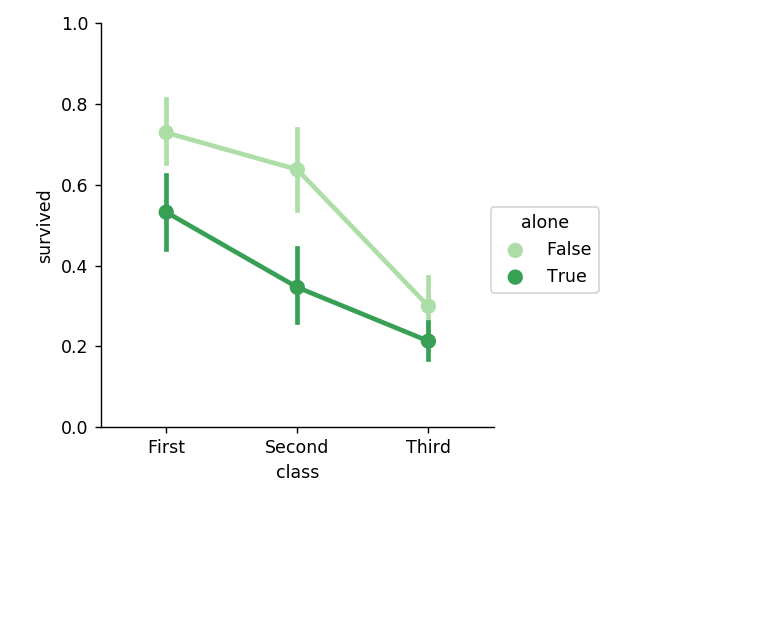

In [55]:
sns.factorplot("class", "survived", data=titanic, order=class_order, hue="alone", palette="Greens").set(ylim=(0, 1));

### Effect of traveling alone on men & women

What about men and women who were traveling alone?

<IPython.core.display.Javascript object>


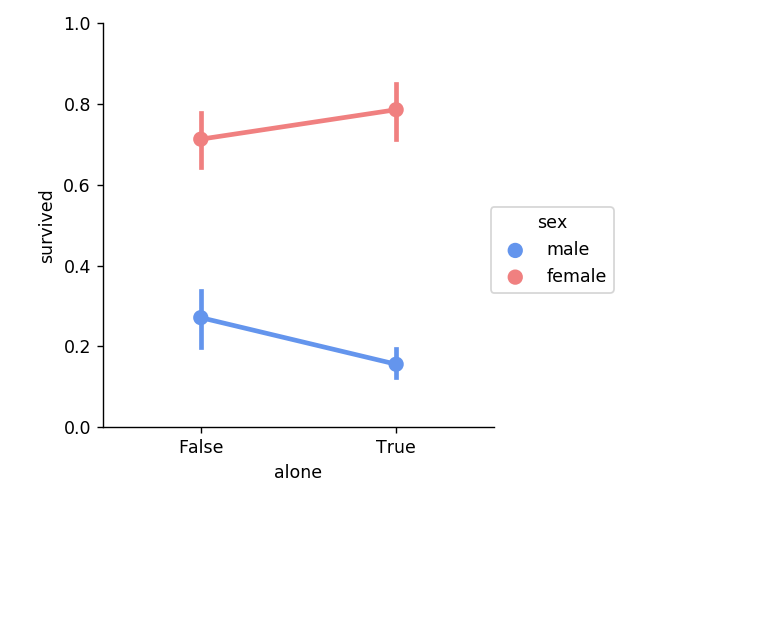

In [56]:
sns.factorplot("alone", "survived", data=titanic, hue="sex", palette=pal).set(ylim=(0, 1));

### Effect of traveling alone by class

<IPython.core.display.Javascript object>


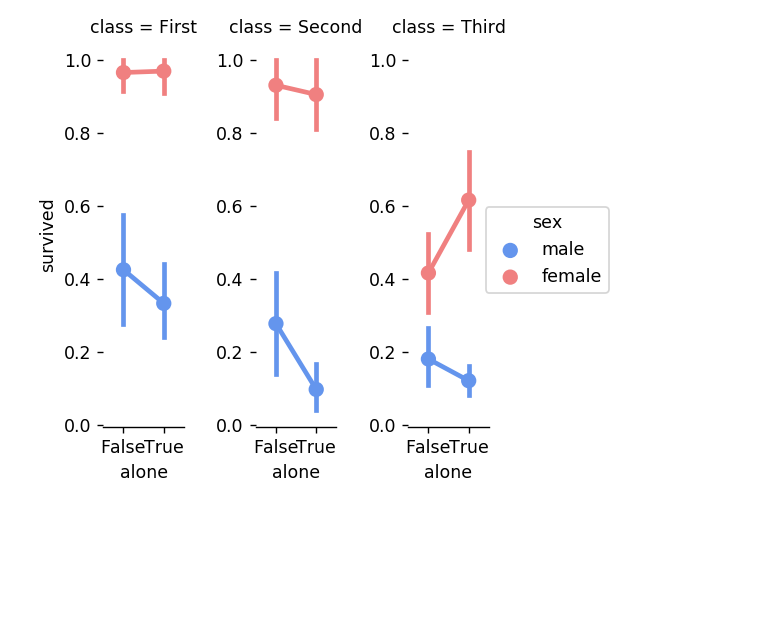

In [57]:
fg = sns.factorplot("alone", "survived", data=titanic, hue="sex",
                    col="class", col_order=class_order, palette=pal, aspect=.33)
fg.despine(left=True);